# Importing Libraries

In [1]:
# Standard Libraries
import math
from math import pi
import itertools
from collections import Counter
from itertools import combinations

# Data Handling
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
from IPython.display import display
%matplotlib inline

# Statistical Libraries
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Machine Learning Libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score, mean_squared_error, 
                             r2_score, mean_absolute_error, roc_curve, roc_auc_score, auc, 
                             precision_recall_fscore_support, cohen_kappa_score, make_scorer)
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV, StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, OrdinalEncoder, 
                                   OneHotEncoder, PolynomialFeatures)
from sklearn.svm import SVC

# Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Genetic Programming Library
from gplearn.genetic import SymbolicClassifier

# Imbalanced-Learn Library
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# Other Third-Party Libraries
from sklearn_extra.cluster import KMedoids
import gower
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# DMBA Library
from dmba import (regressionSummary, classificationSummary, exhaustive_search, 
                  backward_elimination, forward_selection, stepwise_selection, 
                  liftChart, gainsChart, plotDecisionTree, adjusted_r2_score, 
                  AIC_score, BIC_score)

# Patsy
import patsy
from patsy import dmatrices

# Turn Off Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load cleaned dataset
churn_df = pd.read_csv('/Users/williamjowens/Desktop/Datasets/clean_df.csv')
churn_df.head()

,call_failures,complaint,months_subscribed,charge_amt,total_call_secs,total_calls,total_texts,distinct_calls,age_group,tariff_plan,active_status,customer_value,churn
0,8,0,38,0,4370,71,5,17,3,0,1,197.640,0
1,0,0,39,0,318,5,7,4,2,0,0,46.035,0
2,10,0,37,0,2453,60,359,24,3,0,1,1536.520,0
3,10,0,38,0,4198,66,1,35,1,0,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,0,1,145.805,0


In [3]:
# Shape
print(churn_df.shape)

(3150, 13)


In [4]:
# Columns
print(churn_df.columns)

Index(['call_failures', 'complaint', 'months_subscribed', 'charge_amt',
       'total_call_secs', 'total_calls', 'total_texts', 'distinct_calls',
       'age_group', 'tariff_plan', 'active_status', 'customer_value', 'churn'],
      dtype='object')


# Predictive Analysis

## Partitioning the Data

In [5]:
# Define the variables
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']

# Split the data
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.50, stratify=y, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.40, stratify=y_tmp, random_state=0)

print('Training Set:   ', X_train.shape)
print('Validation Set: ', X_val.shape)
print('Test Set:       ', X_test.shape)

Training Set:    (1575, 12)
Validation Set:  (945, 12)
Test Set:        (630, 12)


In [6]:
# Define column groups
numeric_features = ['call_failures', 'months_subscribed', 'total_call_secs', 
                    'total_calls', 'total_texts', 'distinct_calls', 'customer_value']
binary_features = ['complaint', 'tariff_plan', 'active_status']
ordinal_features = ['charge_amt', 'age_group']
original_nominal_features = []
interaction_columns = ['complaint', 'active_status']
categorical_features = ['cluster_label']

## Custom Transformers

In [7]:
# Custom K-Prototypes transformer
class KPrototypesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, init='Cao', max_iter=100, verbose=0,
                 random_state=None, n_jobs=1, gamma=None, categorical=None):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.verbose = verbose
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.gamma = gamma
        self.categorical = categorical
        self.clusterer_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")

        if X.empty:
            raise ValueError("Input data for fitting KPrototypesTransformer cannot be empty.")

        if X.isnull().sum().sum() > 0:
            raise ValueError("Input data for fitting KPrototypesTransformer should not contain null values.")

        self.feature_names_ = X.columns.tolist()

        # Convert column names to indices if necessary
        if self.categorical:
            if all(isinstance(col, str) for col in self.categorical):
                categorical_indices = [X.columns.get_loc(col) for col in self.categorical]
            elif all(isinstance(col, int) for col in self.categorical):
                categorical_indices = self.categorical
            else:
                raise ValueError("Categorical indices must be a list of strings or integers")
        else:
            raise ValueError("Categorical columns must be specified")

        self.clusterer_ = KPrototypes(n_clusters=self.n_clusters, init=self.init,
                                      n_init=1, max_iter=self.max_iter, verbose=self.verbose,
                                      random_state=self.random_state, n_jobs=self.n_jobs, gamma=self.gamma)
        self.clusterer_.fit(X, categorical=categorical_indices)

        return self

    def transform(self, X, y=None):
        if self.clusterer_ is None:
            raise RuntimeError("The transformer was not fitted successfully. Please fit it before transforming the data.")

        if not isinstance(X, pd.DataFrame) or not all(elem in X.columns.tolist() for elem in self.feature_names_):
            raise ValueError("Input data structure during transformation does not match the data structure during fitting.")

        # Convert column names to indices if necessary
        if self.categorical:
            if all(isinstance(col, str) for col in self.categorical):
                categorical_indices = [X.columns.get_loc(col) for col in self.categorical]
            elif all(isinstance(col, int) for col in self.categorical):
                categorical_indices = self.categorical
            else:
                raise ValueError("Categorical indices must be a list of strings or integers")
        else:
            raise ValueError("Categorical columns must be specified")

        cluster_labels = self.clusterer_.predict(X, categorical=categorical_indices)

        X_with_cluster = X.copy()
        X_with_cluster['cluster_label'] = cluster_labels

        return X_with_cluster

    def get_feature_names_out(self, input_features=None):
        if not hasattr(self, "clusterer_"):
            raise AttributeError("Error: The KPrototypesTransformer instance is not fitted yet.")
        return ["cluster_label"]

In [8]:
# Custom K-Medoids with Gower's Distance transformer
# We will be using the K-Prototypes transformer in this project, but this clustering transformer could be used instead
class GowerKMedoidsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, method='pam', init='k-medoids++', 
                 max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.method = method
        self.init = init
        self.max_iter = max_iter
        self.random_state = random_state
        self.gower_dist = None
        self.feature_names_ = None
        self.clusterer_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X.columns = X.columns.astype(str)
            self.feature_names_ = X.columns.tolist()

        if X.empty:
            raise ValueError("Input data for fitting GowerKMedoidsTransformer cannot be empty.")

        if X.isnull().sum().sum() > 0:
            raise ValueError("Input data for fitting GowerKMedoidsTransformer should not contain null values.")

        self.gower_dist = gower.gower_matrix(X)

        self.clusterer_ = KMedoids(n_clusters=self.n_clusters, metric='precomputed', 
                                   method=self.method, init=self.init, max_iter=self.max_iter, 
                                   random_state=self.random_state)
        self.clusterer_.fit(self.gower_dist)

        self.medoids_ = X.iloc[self.clusterer_.medoid_indices_].copy()
        
        return self

    def transform(self, X, y=None):
        if self.clusterer_ is None or self.medoids_ is None:
            raise RuntimeError("The transformer was not fitted successfully. Please fit it before transforming the data.")

        if not isinstance(X, pd.DataFrame) or not all(elem in X.columns.tolist() for elem in self.feature_names_):
            raise ValueError("Input data structure during transformation does not match the data structure during fitting.")

        cluster_labels = []
        for i, row in X.iterrows():
            data_x = pd.DataFrame([row], columns=X.columns)
            result = gower.gower_topn(data_x, data_y=self.medoids_, n=1)
            closest_cluster = result['index'][0]
            cluster_labels.append(closest_cluster)

        X_with_cluster = X.copy()
        X_with_cluster['cluster_label'] = cluster_labels

        return X_with_cluster

    def get_feature_names_out(self, input_features=None):
        if not hasattr(self, "clusterer_"):
            raise AttributeError("Error: The GowerKMedoidsTransformer instance is not fitted yet.")
        return ["cluster_label"]

In [9]:
# Custom transformer that wraps around StandardScaler to ensure it returns a DataFrame
class DataFrameScaler(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features):
        self.numeric_features = numeric_features  # features to scale
        self.scaler = StandardScaler()
        self.feature_names_ = None

    def fit(self, X, y=None):
        # Check if numeric_features are in X
        if not all(feature in X.columns for feature in self.numeric_features):
            missing_features = set(self.numeric_features) - set(X.columns)
            raise ValueError(f"The following numeric features are missing in the input data: {missing_features}")

        # Try to fit the scaler and catch exceptions
        try:
            self.scaler.fit(X[self.numeric_features])
        except Exception as e:
            raise RuntimeError(f"An error occurred during fitting: {str(e)}")

        self.feature_names_ = self.numeric_features
        return self

    def transform(self, X):
        # Check if the scaler is fitted
        if not hasattr(self.scaler, 'scale_'):
            raise RuntimeError("This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")

        # Check if numeric_features are in X
        if not all(feature in X.columns for feature in self.numeric_features):
            missing_features = set(self.numeric_features) - set(X.columns)
            raise ValueError(f"The following numeric features are missing in the input data: {missing_features}")

        # Try to transform the data and catch exceptions
        try:
            X_scaled = self.scaler.transform(X[self.numeric_features])
        except Exception as e:
            raise RuntimeError(f"An error occurred during transforming: {str(e)}")

        # Create a dataframe from the scaled data
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.numeric_features, index=X.index)

        # Replace the original numeric columns with the scaled ones
        for feature in self.numeric_features:
            X[feature] = X_scaled_df[feature]

        return X

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_ is None:
            raise RuntimeError("You must fit the transformer before getting feature names")
        return self.feature_names_

In [10]:
# Custom interaction transformer
class InteractionTermTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_columns=None):
        self.interaction_columns = interaction_columns  # columns to interact
        self.feature_names_ = None

    def fit(self, X, y=None):
        # No fitting necessary, but we'll check if the interaction_columns are in X
        if self.interaction_columns:
            if not all(col in X.columns for col in self.interaction_columns):
                missing_cols = list(set(self.interaction_columns) - set(X.columns))
                raise ValueError(f"The following interaction columns are missing in the input data: {missing_cols}")

            if len(self.interaction_columns) != 2:
                raise ValueError("Please provide exactly two columns for interaction.")
        return self

    def transform(self, X):
        if self.interaction_columns:
            # Create the interaction term directly from the original binary features
            col1, col2 = self.interaction_columns
            interaction_term = X[col1] * X[col2]

            # Name of the new interaction feature
            interaction_feature_name = f"{col1}:{col2}"
            self.feature_names_ = [interaction_feature_name]

            # Return the original dataframe with the new interaction feature
            return X.assign(**{interaction_feature_name: interaction_term})
        else:
            # If no interaction_columns are provided, return the original data
            return X

    def get_feature_names_out(self, input_features=None):
        # Handle the case when feature_names_ is not set
        if self.feature_names_ is None:
            return []  # or return a list of default names or raise an error
        return self.feature_names_

In [11]:
# Custom one-hot encoder
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features  # features to encode
        self.encoder = OneHotEncoder(drop='first')
        self.feature_names_ = None

    def fit(self, X, y=None):
        # Encode only the categorical features
        self.encoder.fit(X[self.categorical_features])
        self.feature_names_ = self.encoder.get_feature_names_out(input_features=self.categorical_features)
        return self

    def transform(self, X):
        # Apply encoding only to categorical features
        X_encoded = self.encoder.transform(X[self.categorical_features])
        X_encoded_df = pd.DataFrame(
            X_encoded.toarray(), 
            columns=self.feature_names_,
            index=X.index
        )
        # Keep the other features unchanged
        X_remaining = X.drop(columns=self.categorical_features)
        # Concatenate the one-hot encoded features to the end of the feature set
        return pd.concat([X_remaining, X_encoded_df], axis=1)

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_ is None:
            raise RuntimeError("You must fit the transformer before getting feature names")
        return self.feature_names_

## Pipeline Construction

In [12]:
# Pipeline creation function
def create_model_pipeline(classifier):
    # Initialize transformers
    clustering_transformer = KPrototypesTransformer(n_clusters=3, random_state=42, 
                                                    categorical=['complaint', 'tariff_plan', 'active_status'])
    scaling_transformer = DataFrameScaler(numeric_features=numeric_features)
    interaction_transformer = InteractionTermTransformer(interaction_columns=interaction_columns)
    encoding_transformer = CustomOneHotEncoder(categorical_features=categorical_features)

    # Create the pipeline
    model_pipeline = ImbPipeline(steps=[
        ('clustering', clustering_transformer),  # Clustering comes first
        ('scaling', scaling_transformer),        # Then scaling
        ('interaction', interaction_transformer), # Then interaction
        ('encoding', encoding_transformer),      # Then encoding
        ('smote_tomek', SMOTETomek(random_state=0)), # Balancing the dataset
        ('classifier', classifier)  # Finally, classification
    ])
    
    return model_pipeline

In [13]:
# Define StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [14]:
# Hyperparameter tuning function
def perform_hyperparameter_tuning(model_pipeline, param_dist, X_train, y_train, cv_strategy, n_iter=250, verbose=1, n_jobs=-1, random_state=0):
    # Scoring dictionary
    scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}
    
    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=model_pipeline,
                                       param_distributions=param_dist,
                                       n_iter=n_iter,  # Number of parameter settings that are sampled
                                       cv=cv_strategy,  # stratified k-fold cross-validation
                                       verbose=verbose,  # Verbosity in text output
                                       random_state=random_state,
                                       n_jobs=n_jobs,  # Number of jobs to run in parallel
                                       refit='recall',
                                       scoring=scoring,
                                       error_score='raise')

    # Fit the random search model
    random_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    return best_params, best_score, random_search.best_estimator_

In [15]:
# Define the classifiers
logistic_classifier = LogisticRegression(random_state=0, max_iter=10000)
rf_classifier = RandomForestClassifier(random_state=0)
svm_classifier = SVC(random_state=0, probability=True)
xgb_classifier = XGBClassifier(random_state=0, eval_metric='logloss')
histgb_classifier = HistGradientBoostingClassifier(random_state=0)
catboost_classifier = CatBoostClassifier(random_state=0, verbose=0)
gp_classifier = SymbolicClassifier(random_state=0)

In [16]:
# Define the hyperparameters for each classifier

# Logistic Regression
logistic_params = {
    'classifier__C': np.logspace(-4, 4, 10),  # Regularization strength (inverse)
    'classifier__penalty': ['l2'],  # Penalty or regularization type
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Algorithm for optimization problem
}

# Random Forest
rf_params = {
    'classifier__max_depth': [5, 10, 15, 20, 25], 
    'classifier__max_features': ['sqrt', 'log2', 7, None],
    'classifier__max_samples': [0.3, 0.5, 0.8],
    'classifier__min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'classifier__min_samples_split': [2, 10, 20, 30, 40, 50],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__n_estimators': [10, 50, 100, 150, 200]
}

# SVM
svm_params = {
    'classifier__C': np.logspace(-3, 2, 6),  # Regularization parameter
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type to be used in the algorithm
    'classifier__degree': [2, 3, 4],  # Degree of the polynomial kernel function
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
    'classifier__shrinking': [True, False]  # Whether to use the shrinking heuristic
}

# XGBoost
xgb_params = {
    'classifier__max_depth': [5, 10, 15, 20, 25],
    'classifier__min_child_weight': [1, 3, 5, 7],
    'classifier__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'classifier__max_delta_step': [0, 1, 2, 3, 4],
    'classifier__n_estimators': [10, 50, 100, 150, 200],
    'classifier__subsample': [0.1, 0.3, 0.5, 0.7, 1],
    'classifier__colsample_bytree': [0.3, 0.5, 0.7, 1],
    'classifier__tree_method': ['exact', 'approx', 'hist'],
    'classifier__sampling_method': ['uniform']
}

# HistGradientBoosting
histgb_params = {
    'classifier__max_iter': [100, 200, 300],  # Number of boosting iterations
    'classifier__max_depth': [5, 10, 15, 20, 25],  # Maximum depth of the individual regression estimators
    'classifier__min_samples_leaf': [1, 2, 4, 8],  # The minimum number of samples required to be at a leaf node
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # Boosting learning rate
    'classifier__max_bins': [200, 255],  # The maximum number of bins used to build the histograms
}

# CatBoost
catboost_params = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'classifier__depth': [5, 7, 10, 15],  # Depth of the tree
    'classifier__iterations': [100, 200, 300],  # Number of trees to fit
    'classifier__od_type': ['IncToDec', 'Iter'],  # Type of overfitting detector to use
    'classifier__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],  # The type of growing policy for the trees
    'classifier__auto_class_weights': ['None', 'Balanced', 'SqrtBalanced']  # For imbalanced datasets
}

# Genetic Programming
gp_params = {
    'classifier__population_size': [100, 200, 300],  # Number of programs in each generation
    'classifier__generations': [10, 20, 40],  # Number of generations to evolve
    'classifier__tournament_size': [10, 20, 40],  # Number of programs selected for breeding each generation
    'classifier__const_range': [(-1.0, 1.0), (-0.5, 0.5)],  # The range of randomly generated constants
    'classifier__init_depth': [(2, 6), (3, 7)],  # The range of tree depths for the initial population
    'classifier__init_method': ['half and half', 'grow', 'full'],  # The method used to create the initial population
    'classifier__function_set': [('add', 'sub', 'mul', 'div'), ('add', 'sub', 'mul')],  # The set of functions to use in the programs
}

In [17]:
# Create model pipelines
logistic_pipeline = create_model_pipeline(logistic_classifier)
rf_pipeline = create_model_pipeline(rf_classifier)
svm_pipeline = create_model_pipeline(svm_classifier)
xgb_pipeline = create_model_pipeline(xgb_classifier)
histgb_pipeline = create_model_pipeline(histgb_classifier)
catboost_pipeline = create_model_pipeline(catboost_classifier)
gp_pipeline = create_model_pipeline(gp_classifier)

In [18]:
pipelines = {
    'Logistic Regression': logistic_pipeline,
    'Random Forest': rf_pipeline,
    'SVM': svm_pipeline,
    'XGBoost': xgb_pipeline,
    'HistGradientBoosting': histgb_pipeline,
    'CatBoost': catboost_pipeline,
    'Genetic Programming': gp_pipeline,
}

# Loop through the dictionary and print each pipeline
for name, pipeline in pipelines.items():
    print(f"{name} Pipeline:")
    display(pipeline)
    print("\n")  # add a newline for readability

Logistic Regression Pipeline:


Pipeline(steps=[('clustering',
                 KPrototypesTransformer(categorical=['complaint', 'tariff_plan',
                                                     'active_status'],
                                        random_state=42)),
                ('scaling',
                 DataFrameScaler(numeric_features=['call_failures',
                                                   'months_subscribed',
                                                   'total_call_secs',
                                                   'total_calls', 'total_texts',
                                                   'distinct_calls',
                                                   'customer_value'])),
                ('interaction',
                 InteractionTermTransformer(interaction_columns=['complaint',
                                                                 'active_status'])),
                ('encoding',
                 CustomOneHotEncoder(categorical_features=['cluster_label'])),
                ('smote_tomek', SMOTETomek(random_state=0)),
                ('classifier',
                 LogisticRegression(max_iter=10000, random_state=0))])



Random Forest Pipeline:


Pipeline(steps=[('clustering',
                 KPrototypesTransformer(categorical=['complaint', 'tariff_plan',
                                                     'active_status'],
                                        random_state=42)),
                ('scaling',
                 DataFrameScaler(numeric_features=['call_failures',
                                                   'months_subscribed',
                                                   'total_call_secs',
                                                   'total_calls', 'total_texts',
                                                   'distinct_calls',
                                                   'customer_value'])),
                ('interaction',
                 InteractionTermTransformer(interaction_columns=['complaint',
                                                                 'active_status'])),
                ('encoding',
                 CustomOneHotEncoder(categorical_features=['cluster_label'])),
                ('smote_tomek', SMOTETomek(random_state=0)),
                ('classifier', RandomForestClassifier(random_state=0))])



SVM Pipeline:


Pipeline(steps=[('clustering',
                 KPrototypesTransformer(categorical=['complaint', 'tariff_plan',
                                                     'active_status'],
                                        random_state=42)),
                ('scaling',
                 DataFrameScaler(numeric_features=['call_failures',
                                                   'months_subscribed',
                                                   'total_call_secs',
                                                   'total_calls', 'total_texts',
                                                   'distinct_calls',
                                                   'customer_value'])),
                ('interaction',
                 InteractionTermTransformer(interaction_columns=['complaint',
                                                                 'active_status'])),
                ('encoding',
                 CustomOneHotEncoder(categorical_features=['cluster_label'])),
                ('smote_tomek', SMOTETomek(random_state=0)),
                ('classifier', SVC(probability=True, random_state=0))])



XGBoost Pipeline:


Pipeline(steps=[('clustering',
                 KPrototypesTransformer(categorical=['complaint', 'tariff_plan',
                                                     'active_status'],
                                        random_state=42)),
                ('scaling',
                 DataFrameScaler(numeric_features=['call_failures',
                                                   'months_subscribed',
                                                   'total_call_secs',
                                                   'total_calls', 'total_texts',
                                                   'distinct_calls',
                                                   'customer_value'])),
                ('interaction',
                 InteractionTermTransformer(interaction_colum...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])



HistGradientBoosting Pipeline:


Pipeline(steps=[('clustering',
                 KPrototypesTransformer(categorical=['complaint', 'tariff_plan',
                                                     'active_status'],
                                        random_state=42)),
                ('scaling',
                 DataFrameScaler(numeric_features=['call_failures',
                                                   'months_subscribed',
                                                   'total_call_secs',
                                                   'total_calls', 'total_texts',
                                                   'distinct_calls',
                                                   'customer_value'])),
                ('interaction',
                 InteractionTermTransformer(interaction_columns=['complaint',
                                                                 'active_status'])),
                ('encoding',
                 CustomOneHotEncoder(categorical_features=['cluster_label'])),
                ('smote_tomek', SMOTETomek(random_state=0)),
                ('classifier', HistGradientBoostingClassifier(random_state=0))])



CatBoost Pipeline:


Pipeline(steps=[('clustering',
                 KPrototypesTransformer(categorical=['complaint', 'tariff_plan',
                                                     'active_status'],
                                        random_state=42)),
                ('scaling',
                 DataFrameScaler(numeric_features=['call_failures',
                                                   'months_subscribed',
                                                   'total_call_secs',
                                                   'total_calls', 'total_texts',
                                                   'distinct_calls',
                                                   'customer_value'])),
                ('interaction',
                 InteractionTermTransformer(interaction_columns=['complaint',
                                                                 'active_status'])),
                ('encoding',
                 CustomOneHotEncoder(categorical_features=['cluster_label'])),
                ('smote_tomek', SMOTETomek(random_state=0)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x179897280>)])



Genetic Programming Pipeline:


Pipeline(steps=[('clustering',
                 KPrototypesTransformer(categorical=['complaint', 'tariff_plan',
                                                     'active_status'],
                                        random_state=42)),
                ('scaling',
                 DataFrameScaler(numeric_features=['call_failures',
                                                   'months_subscribed',
                                                   'total_call_secs',
                                                   'total_calls', 'total_texts',
                                                   'distinct_calls',
                                                   'customer_value'])),
                ('interaction',
                 InteractionTermTransformer(interaction_columns=['complaint',
                                                                 'active_status'])),
                ('encoding',
                 CustomOneHotEncoder(categorical_features=['cluster_label'])),
                ('smote_tomek', SMOTETomek(random_state=0)),
                ('classifier', SymbolicClassifier(random_state=0))])

## Hyperparameter Tuning

In [19]:
# Logistic Regression tuning
best_params_logistic, best_score_logistic, best_estimator_logistic = perform_hyperparameter_tuning(
    logistic_pipeline, logistic_params, X_train, y_train, cv_strategy=skf)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [20]:
# Random Forest tuning
best_params_rf, best_score_rf, best_estimator_rf = perform_hyperparameter_tuning(
    rf_pipeline, rf_params, X_train, y_train, cv_strategy=skf)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


In [21]:
# Support Vector Machine tuning
best_params_svm, best_score_svm, best_estimator_svm = perform_hyperparameter_tuning(
    svm_pipeline, svm_params, X_train, y_train, cv_strategy=skf)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


In [22]:
# XGBoost tuning
best_params_xgb, best_score_xgb, best_estimator_xgb = perform_hyperparameter_tuning(
    xgb_pipeline, xgb_params, X_train, y_train, cv_strategy=skf)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


In [23]:
# Histogram-based Gradient Boosting tuning
best_params_histgb, best_score_histgb, best_estimator_histgb = perform_hyperparameter_tuning(
    histgb_pipeline, histgb_params, X_train, y_train, cv_strategy=skf)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


In [24]:
# CatBoost tuning
best_params_catboost, best_score_catboost, best_estimator_catboost = perform_hyperparameter_tuning(
    catboost_pipeline, catboost_params, X_train, y_train, cv_strategy=skf)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


In [25]:
# Symbolic Classifier tuning
best_params_gp, best_score_gp, best_estimator_gp = perform_hyperparameter_tuning(
    gp_pipeline, gp_params, X_train, y_train, cv_strategy=skf)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


## Model Selection

In [26]:
# Function to get predictions and probabilities after retraining the best estimator
def get_predictions_and_probabilities(random_search, X_train, y_train, X_data):
    """
    Retrain the best estimator on the entire training set and make predictions on new data.
    
    Returns: Predictions and probabilities for the new data.
    """
    # Check the type of object and get the best estimator or use the pipeline directly
    if isinstance(random_search, RandomizedSearchCV):
        best_estimator = random_search.best_estimator_
    elif isinstance(random_search, Pipeline):
        best_estimator = random_search
    else:
        raise TypeError(f"Unexpected object type: {type(random_search)}")

    # Fit it to the entire training data
    best_estimator.fit(X_train, y_train)

    # Make predictions
    y_pred = best_estimator.predict(X_data)

    # Check if the model supports the predict_proba method
    if hasattr(best_estimator, "predict_proba"):
        # Predict probabilities
        y_prob = best_estimator.predict_proba(X_data)
        
        # Diagnostic print
        print(f"Probabilities shape: {y_prob.shape}")
        print(f"Probabilities sample: {y_prob[:5]}")  # print the first 5 probabilities
    else:
        print(f"The model {type(best_estimator).__name__} does not support predict_proba.")
        y_prob = None

    return y_pred, y_prob

In [27]:
# Function to get performance metrics
def metrics_df(y_true, y_pred, y_prob):
    """
    Evaluate the model predictions.
    
    Returns: A DataFrame with accuracy, recall, precision, F1 score, and ROC-AUC score.
    """
    # Metrics calculation
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Check if y_prob is not None and is two-dimensional with more than one column
    if y_prob is not None and len(y_prob.shape) == 2 and y_prob.shape[1] > 1:
        roc_auc = roc_auc_score(y_true, y_prob[:, 1])  # probability for the positive class
    else:
        roc_auc = None

    # Creating a DataFrame with the metrics
    df = pd.DataFrame({
        'accuracy': [accuracy],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1],
        'roc_auc': [roc_auc]
    })

    return df

In [28]:
# Uses the previous helper functions to evaluate multiple models and get the relevant results
def evaluate_models(models, X_train, y_train, X_val, y_val):
    """
    Evaluate multiple models and return their predictions, probabilities, and performance metrics.

    Returns: A dictionary containing each model's predictions, probabilities, and performance metrics.
    """
    all_results = {}
    
    for model_name, random_search in models.items():
        # Get predictions and probabilities
        y_pred, y_prob = get_predictions_and_probabilities(random_search, X_train, y_train, X_val)
        
        # Get performance metrics
        metrics = metrics_df(y_val, y_pred, y_prob)
        
        # Store results in the dictionary
        all_results[model_name] = {
            'predictions': y_pred,
            'probabilities': y_prob,
            'metrics': metrics
        }
    
    return all_results

In [29]:
# Dictionary of all models and their best estimators from RandomizedSearchCV
models = {
    'Logistic Regression': best_estimator_logistic,
    'Random Forest': best_estimator_rf,
    'SVM': best_estimator_svm,
    'XGBoost': best_estimator_xgb,
    'HistGB': best_estimator_histgb,
    'CatBoost': best_estimator_catboost,
    'Genetic Programming': best_estimator_gp
}

In [30]:
# Evaluate all models
all_model_results = evaluate_models(models, X_train, y_train, X_val, y_val)

Probabilities shape: (945, 2)
Probabilities sample: [[0.49629868 0.50370132]
 [0.66639701 0.33360299]
 [0.54575575 0.45424425]
 [0.46032877 0.53967123]
 [0.47909607 0.52090393]]
Probabilities shape: (945, 2)
Probabilities sample: [[0.12971635 0.87028365]
 [0.99112688 0.00887312]
 [0.97854767 0.02145233]
 [0.33984299 0.66015701]
 [0.46879833 0.53120167]]
Probabilities shape: (945, 2)
Probabilities sample: [[0.50554154 0.49445846]
 [0.57052372 0.42947628]
 [0.53260655 0.46739345]
 [0.48950395 0.51049605]
 [0.5        0.5       ]]
Probabilities shape: (945, 2)
Probabilities sample: [[0.07307392 0.9269261 ]
 [0.9764983  0.02350171]
 [0.9723928  0.02760719]
 [0.50073516 0.49926484]
 [0.67685807 0.32314193]]
Probabilities shape: (945, 2)
Probabilities sample: [[0.00723671 0.99276329]
 [0.9960939  0.0039061 ]
 [0.99480268 0.00519732]
 [0.42520495 0.57479505]
 [0.91693829 0.08306171]]
Probabilities shape: (945, 2)
Probabilities sample: [[0.36800604 0.63199396]
 [0.7430839  0.2569161 ]
 [0.7198

In [31]:
# Display the metrics for all models in a loop
for model_name, results in all_model_results.items():
    print(f"Metrics for {model_name}:")
    display(results['metrics'])
    print("\n")

Metrics for Logistic Regression:


,accuracy,recall,precision,f1_score,roc_auc
0,0.684656,0.858108,0.314356,0.460145,0.823722




Metrics for Random Forest:


,accuracy,recall,precision,f1_score,roc_auc
0,0.839153,0.905405,0.492647,0.638095,0.935675




Metrics for SVM:


,accuracy,recall,precision,f1_score,roc_auc
0,0.437037,0.993243,0.216814,0.355932,0.803982




Metrics for XGBoost:


,accuracy,recall,precision,f1_score,roc_auc
0,0.912169,0.824324,0.681564,0.746177,0.953241




Metrics for HistGB:


,accuracy,recall,precision,f1_score,roc_auc
0,0.93545,0.831081,0.773585,0.801303,0.962028




Metrics for CatBoost:


,accuracy,recall,precision,f1_score,roc_auc
0,0.873016,0.898649,0.558824,0.689119,0.95144




Metrics for Genetic Programming:


,accuracy,recall,precision,f1_score,roc_auc
0,0.477249,1.0,0.23053,0.374684,0.863428


In [32]:
# Radar chart function for model comparison
def plot_model_comparison(data):
    """
    Plots a radar chart comparing different models across multiple metrics.

    Parameters:
    data (dict): Dictionary containing models and their corresponding metrics.
                 Example format:
                 {
                     'Model': ['Model1', 'Model2'],
                     'Accuracy': [0.9, 0.85],
                     'Recall': [0.8, 0.95],
                     ...
                 }
    """
    # Convert data to DataFrame for easier manipulation
    df = pd.DataFrame(data)

    # Number of variables we're plotting.
    num_vars = len(df.columns) - 1  # exclude 'Model'

    # Compute angle of each axis
    angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # "complete the loop"

    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Helper function to plot each model on the radar chart
    def add_to_radar(model, color):
        values = df.loc[df['Model'] == model].drop('Model', axis=1).values.flatten().tolist()
        values += values[:1]  # "complete the loop"
        ax.plot(angles, values, color=color, linewidth=2, label=model)
        ax.fill(angles, values, color=color, alpha=0.25)

    # Add each model to the radar chart with different colors
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'white']
    for i, model in enumerate(df['Model']):
        add_to_radar(model, colors[i % len(colors)])  # use modulo to avoid running out of colors

    # Fix axis to labels and add gridlines
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), df.columns[1:])
    ax.set_rlabel_position(180 / num_vars)

    ax.set_ylim(0, 1)  # Assuming metrics are normalized between 0 and 1

    plt.title('Model Comparison across Metrics')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

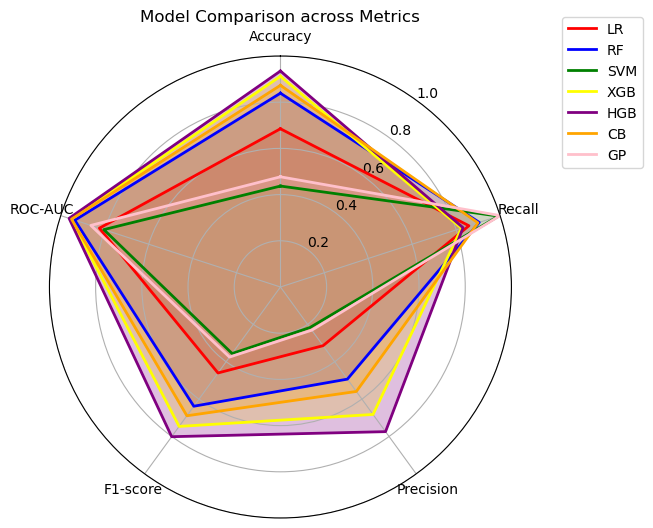

In [33]:
# Create data dictionary
data = {
    'Model': ['LR', 'RF', 'SVM', 'XGB', 'HGB', 'CB', 'GP'],
    'Accuracy': [0.685, 0.839, 0.437, 0.912, 0.935, 0.873, 0.477],
    'Recall': [0.858, 0.905, 0.993, 0.824, 0.831, 0.899, 1.000],
    'Precision': [0.314, 0.493, 0.217, 0.682, 0.774, 0.559, 0.231],
    'F1-score': [0.460, 0.638, 0.356, 0.746, 0.801, 0.689, 0.375],
    'ROC-AUC': [0.824, 0.936, 0.804, 0.953, 0.962, 0.951, 0.863]
}

# Call the function
plot_model_comparison(data)

## Test Evaluation

In [34]:
# Step 1: Combine the training and validation sets
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

# Step 2: Retrain the models
top_models = {
    'HistGB': best_estimator_histgb,
    'XGBoost': best_estimator_xgb
}

for model_name, model in top_models.items():
    print(f"Retraining {model_name} on full training set...")
    model.fit(X_full_train, y_full_train)  # Retraining happens here
    print(f"{model_name} retraining complete.")

Retraining HistGB on full training set...
HistGB retraining complete.
Retraining XGBoost on full training set...
XGBoost retraining complete.


In [35]:
# Function to evaluate models on the test set
def evaluate_on_test(models, X_test, y_test):
    """
    Evaluate selected models on the test set.

    Returns: A dictionary containing each model's performance metrics on the test set.
    """
    test_results = {}

    for model_name, model in models.items():
        # Predictions and probabilities on the test set
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Calculate metrics
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_prob) if y_test_prob is not None else None

        # Store in the results dictionary
        test_results[model_name] = {
            'accuracy': test_accuracy,
            'recall': test_recall,
            'precision': test_precision,
            'f1': test_f1,
            'roc_auc': test_roc_auc,
            'predictions': y_test_pred,
            'probabilities': y_test_prob
        }

    return test_results

In [36]:
# Call the function
test_metrics = evaluate_on_test(top_models, X_test, y_test)

In [37]:
# Display results
for model_name, metrics in test_metrics.items():
    print(f"Test Results for {model_name}:")
    for metric_name, metric_value in metrics.items():
        if metric_name in ['predictions', 'probabilities']:
            continue
        print(f"{metric_name}: {metric_value}")
    print("\n")

Test Results for HistGB:
accuracy: 0.9380952380952381
recall: 0.9292929292929293
precision: 0.7419354838709677
f1: 0.8251121076233184
roc_auc: 0.9763453746504593


Test Results for XGBoost:
accuracy: 0.9349206349206349
recall: 0.9090909090909091
precision: 0.7377049180327869
f1: 0.8144796380090498
roc_auc: 0.9764880442846545




## Plotting Results

In [38]:
# ROC Comparison Plot
def plot_roc_curves(models, X_test, y_test):
    """
    Plots ROC curves for the provided models.
    """
    # Initialize plot
    plt.figure(figsize=(10, 8))

    # Calculate ROC curve and ROC area for each model
    for model_name, model in models.items():
        # Check if the model has the predict_proba method
        if hasattr(model, "predict_proba"):
            y_test_prob = model.predict_proba(X_test)[:, 1]
        else:
            # For models without predict_proba, like SVC with default settings, we use decision_function
            y_test_prob = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        lw = 2  # line width
        plt.plot(fpr, tpr, lw=lw, label=f'{model_name} (area = {roc_auc:.2f})')
    
    # Plot Base Rate ROC
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Base Rate (area = 0.50)')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    # Show plot
    plt.show()

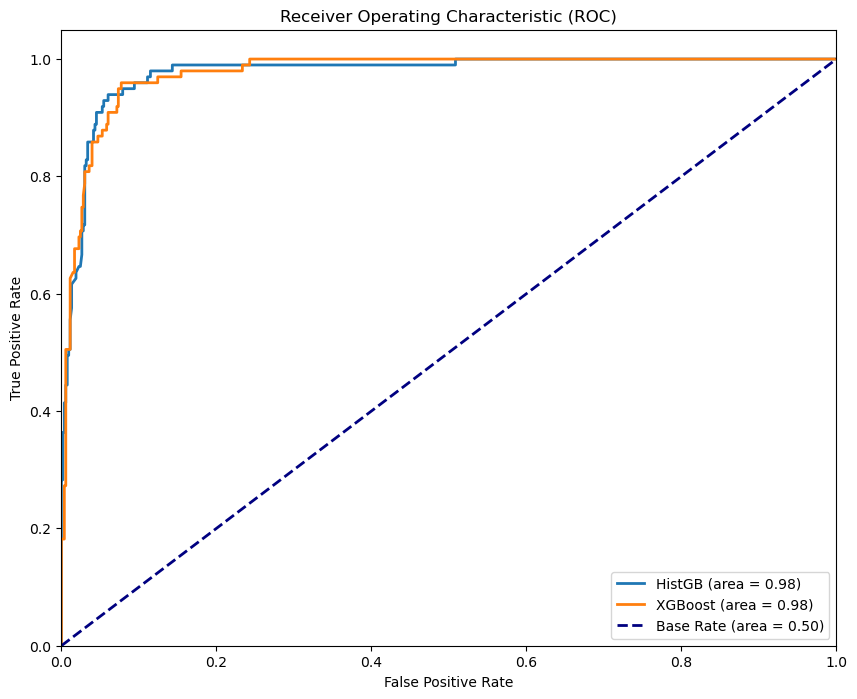

In [39]:
# Plot the ROC curves
plot_roc_curves(top_models, X_test, y_test)

In [40]:
# Diverging Bar Plot
def plot_diverging_bars(test_metrics, model1, model2, color1, color2):
    """
    Plots the model metrics for comparison, arranged as a diverging bar plot.
    """
    # Metrics to display
    metrics = ['recall', 'accuracy', 'precision', 'f1', 'roc_auc']
    
    # Extracting scores for each model and making them diverge from the midpoint
    model1_scores = [test_metrics[model1][metric] for metric in metrics]
    model2_scores = [-test_metrics[model2][metric] for metric in metrics]  # negative for divergence
    
    # Midpoint for diverging bars
    mid_point = 0

    # Creating the bar width (making bars thicker)
    bar_width = 0.8

    # Position of bars on y axis
    indices = np.arange(len(model1_scores))

    fig, ax = plt.subplots(figsize=(12, 6))

    # Creating the bars
    model1_bars = ax.barh(indices, model1_scores, bar_width, 
                           label=model1, color=color1, edgecolor='black')
    model2_bars = ax.barh(indices, model2_scores, bar_width, 
                            label=model2, color=color2, edgecolor='black')

    # Adding labels
    ax.set(yticks=indices, yticklabels=metrics, ylim=[-1, len(model1_scores)])
    ax.legend()

    # Adding a vertical line in the middle
    ax.axvline(mid_point, linestyle='--', color='black', linewidth=0.8)

    # Adding value labels on bars
    for bar in model1_bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{abs(bar.get_width()):.3f}', 
                va='center', ha='right', color='black', weight='bold', fontsize=10)

    for bar in model2_bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{abs(bar.get_width()):.3f}', 
                va='center', ha='left', color='black', weight='bold', fontsize=10)

    plt.xlabel("Score")
    plt.ylabel("Evaluation Metrics")
    plt.title("Comparison of Model Performance")
    plt.tight_layout()
    plt.show()

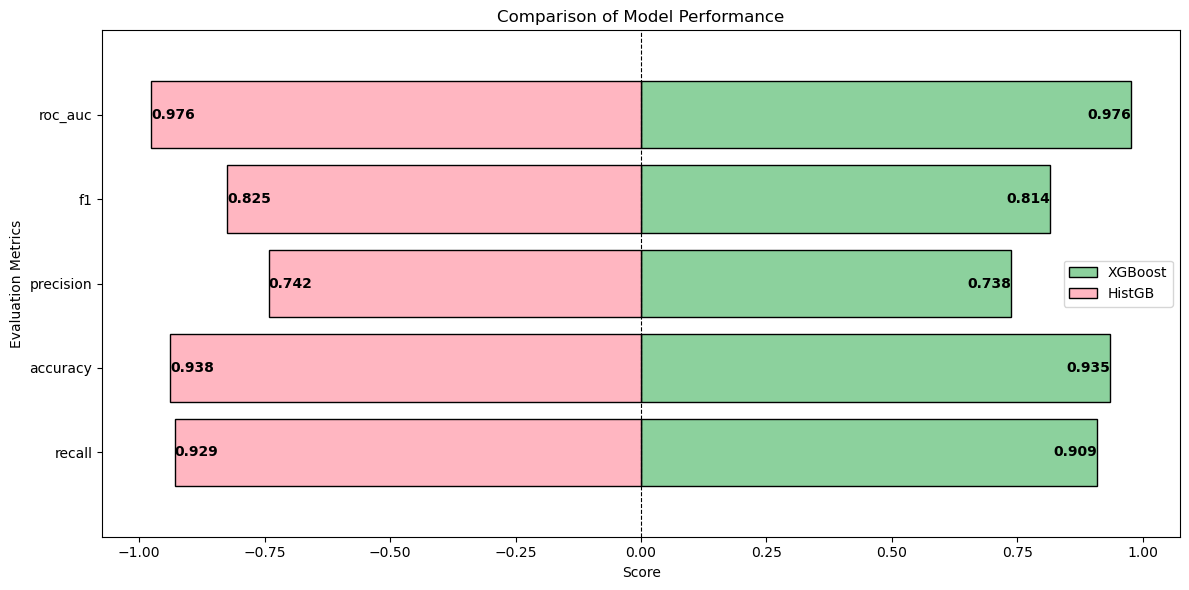

In [41]:
# Specify the models and corresponding colors in the plot
model1 = 'XGBoost'
model2 = 'HistGB'
color1 = '#8CD19D'  # color for model1
color2 = '#FFB6C1'  # color for model2

plot_diverging_bars(test_metrics, model1, model2, color1, color2)

In [42]:
# Side-by-Side Confusion Matrices
def plot_confusion_matrices(models, X_test, y_test):
    """
    Plots side-by-side confusion matrices for the provided models.
    """
    # Number of models
    n_models = len(models)

    # Setting up the subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=n_models, figsize=(10 * n_models, 7))

    # Check if there's only one model (axes won't be a list in this case)
    if n_models == 1:
        axes = [axes]

    for ax, (name, model) in zip(axes, models.items()):
        # Predict the values and create a confusion matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Displaying the confusion matrix
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               title=name,
               ylabel='True label',
               xlabel='Predicted label')

        # Loop over data dimensions and create text annotations
        fmt = 'd'  # format as integer
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

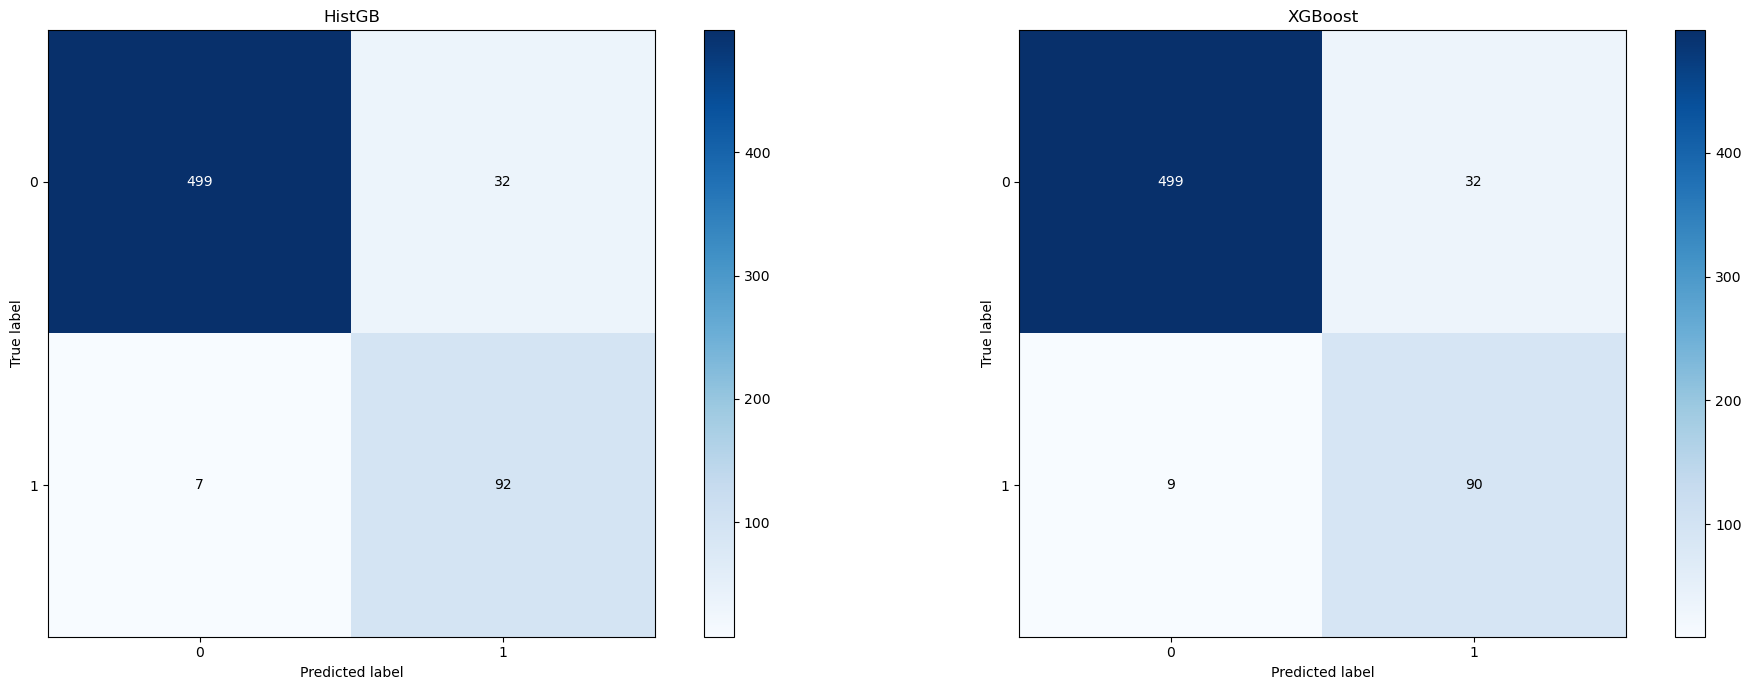

In [43]:
# Call the function with models, test features, and test target
plot_confusion_matrices(top_models, X_test, y_test)

## Model Saving

In [44]:
from joblib import dump

# Save models to a file
for model_name, model in top_models.items():
    filename = f"{model_name.replace(' ', '_').lower()}_model.joblib"
    dump(model, filename)
    print(f"{model_name} saved as {filename}")

HistGB saved as histgb_model.joblib
XGBoost saved as xgboost_model.joblib


In [45]:
from joblib import load

# Load from file
xgb_model = load('xgboost_model.joblib')
histgb_model = load('histgb_model.joblib')

## Feature Importance

In [46]:
# Get feature importances from pipeline
def extract_feature_importances_from_pipeline(pipeline, original_features, interaction_feature, cluster_labels_feature):
    """
    Extract feature importances from a pipeline object's classifier, adapted for specific pipeline behavior.

    Returns: A dictionary with feature names as keys and their importances as values.
    """
    # Access the classifier step
    classifier = pipeline.named_steps.get('classifier')

    # Check if the classifier exists and has the attribute feature_importances or feature_importances_
    if classifier is None or (not hasattr(classifier, 'feature_importances_') and not hasattr(classifier, 'feature_importances')):
        raise AttributeError("The pipeline does not contain a classifier with feature importances.")

    # Get feature importances from the classifier
    feature_importances = classifier.feature_importances_ if hasattr(classifier, 'feature_importances_') else classifier.feature_importances

    # Initialize an empty list to store feature names
    feature_names = []

    # Original features and the interaction feature
    feature_names.extend(original_features)
    feature_names.append(interaction_feature)

    # Handle cluster labels
    remaining_importances_count = len(feature_importances) - len(feature_names)
    for i in range(1, remaining_importances_count + 1):  # starting from 1, not 0
        feature_names.append(f"{cluster_labels_feature}_{i}")

    # Match importances with feature names
    feature_importances_dict = dict(zip(feature_names, feature_importances))

    return feature_importances_dict

In [47]:
# List of original features
original_features = [
    'call_failures', 'complaint', 'months_subscribed', 'charge_amt',
    'total_call_secs', 'total_calls', 'total_texts', 'distinct_calls',
    'age_group', 'tariff_plan', 'active_status', 'customer_value'
]

In [48]:
# Engineered features
interaction_feature = 'complaint:active_status'
cluster_labels_feature = 'cluster_label'

In [49]:
# Call the function
feature_importances_dict = extract_feature_importances_from_pipeline(
    pipeline=xgb_model,
    original_features=original_features,
    interaction_feature=interaction_feature,
    cluster_labels_feature=cluster_labels_feature
)

In [50]:
# Sort the feature importances in descending order
sorted_importances = sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: active_status, Importance: 0.49651026725769043
Feature: complaint, Importance: 0.2049872875213623
Feature: months_subscribed, Importance: 0.045901570469141006
Feature: total_call_secs, Importance: 0.04178312048316002
Feature: age_group, Importance: 0.04125527665019035
Feature: total_calls, Importance: 0.04072657227516174
Feature: customer_value, Importance: 0.03767380863428116
Feature: call_failures, Importance: 0.0336487740278244
Feature: distinct_calls, Importance: 0.03178524225950241
Feature: total_texts, Importance: 0.025728067383170128
Feature: charge_amt, Importance: 0.0
Feature: tariff_plan, Importance: 0.0
Feature: complaint:active_status, Importance: 0.0
Feature: cluster_label_1, Importance: 0.0
Feature: cluster_label_2, Importance: 0.0


In [51]:
# Plot feature importances
def plot_feature_importances(importances_dict):
    """
    Plots the importance values corresponding to each feature.
    """
    # Sort features by importance
    sorted_importances = {k: v for k, v in sorted(importances_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # Create plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(sorted_importances.values()), y=list(sorted_importances.keys()), palette="Blues_d")
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

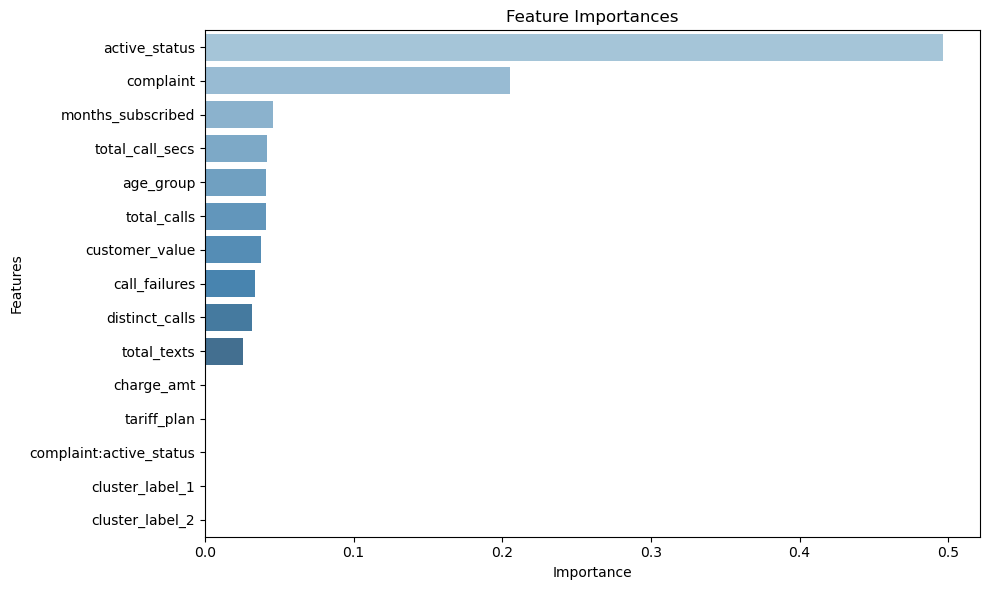

In [52]:
# Call the function
plot_feature_importances(feature_importances_dict)

In [53]:
# Get permutation importances from pipeline
def extract_permutation_importances_from_pipeline(pipeline, X_val, y_val, original_features, interaction_feature, cluster_labels_feature):
    """
    Extract permutation feature importances from a pipeline object's classifier, adapted for specific pipeline behavior.

    Returns: A dictionary with feature names as keys and their importances as values.
    """
    # Access the classifier step
    classifier = pipeline.named_steps.get('classifier')
    if classifier is None:
        raise AttributeError("The pipeline does not contain a classifier.")

    # Transform the validation dataset using the pipeline up to the point before encoding
    pre_encoding_steps = ['clustering', 'scaling', 'interaction']
    X_val_transformed = X_val.copy()
    for step in pre_encoding_steps:
        transformer = pipeline.named_steps[step]
        X_val_transformed = transformer.transform(X_val_transformed)

    # Apply the final encoding step
    X_val_transformed = pipeline.named_steps['encoding'].transform(X_val_transformed)

    # Get permutation importances
    perm_importance = permutation_importance(classifier, X_val_transformed, y_val, n_repeats=30, random_state=0)

    # Build the feature names list
    feature_names = []

    # Add original features and the interaction feature
    feature_names.extend(original_features)
    feature_names.append(interaction_feature)

    # Add cluster labels
    remaining_importances_count = len(perm_importance.importances_mean) - len(feature_names)
    for i in range(1, remaining_importances_count + 1):  # starting from 1, not 0
        feature_names.append(f"{cluster_labels_feature}_{i}")

    # Match importances with feature names
    feature_importances_dict = dict(zip(feature_names, perm_importance.importances_mean))

    return feature_importances_dict

In [54]:
# Call the function
feature_importances_dict = extract_permutation_importances_from_pipeline(
    pipeline=xgb_model,
    X_val=X_test,
    y_val=y_test,
    original_features=original_features,
    interaction_feature=interaction_feature,
    cluster_labels_feature=cluster_labels_feature
)

In [55]:
# Sort the feature importances in descending order
sorted_importances = sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: active_status, Importance: 0.05433862433862435
Feature: complaint, Importance: 0.043862433862433874
Feature: total_call_secs, Importance: 0.03121693121693122
Feature: months_subscribed, Importance: 0.02767195767195768
Feature: call_failures, Importance: 0.022698412698412728
Feature: total_calls, Importance: 0.01767195767195769
Feature: distinct_calls, Importance: 0.015555555555555564
Feature: age_group, Importance: 0.008148148148148137
Feature: total_texts, Importance: 0.003439153439153427
Feature: customer_value, Importance: 0.0015873015873015817
Feature: charge_amt, Importance: 0.0
Feature: tariff_plan, Importance: 0.0
Feature: complaint:active_status, Importance: 0.0
Feature: cluster_label_1, Importance: 0.0
Feature: cluster_label_2, Importance: 0.0


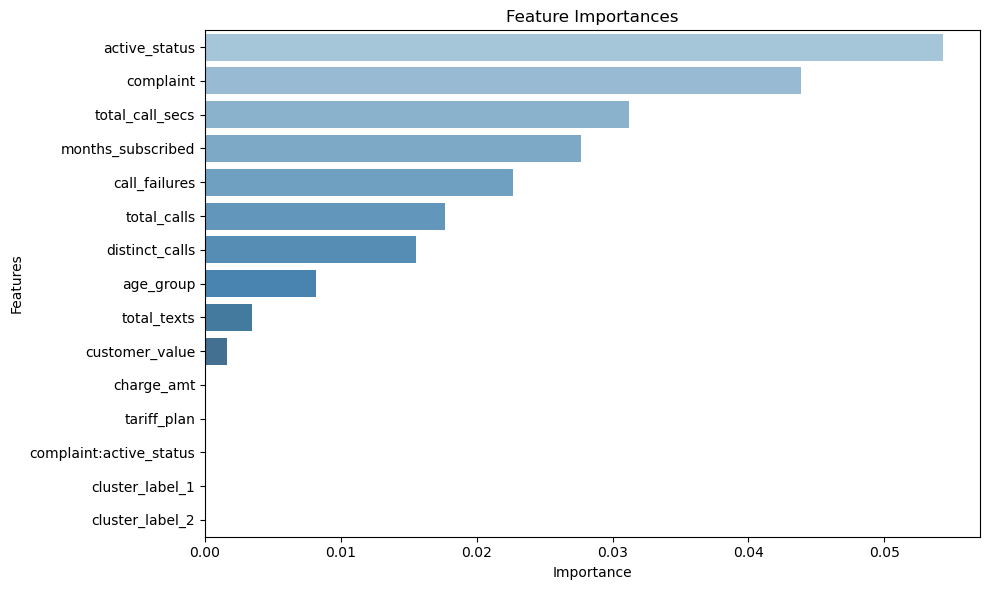

In [56]:
# Plot permutation feature importances
plot_feature_importances(feature_importances_dict)

In [57]:
# Call the function
feature_importances_dict = extract_permutation_importances_from_pipeline(
    pipeline=histgb_model,
    X_val=X_test,
    y_val=y_test,
    original_features=original_features,
    interaction_feature=interaction_feature,
    cluster_labels_feature=cluster_labels_feature
)

In [58]:
# Sort the feature importances in descending order
sorted_importances = sorted(feature_importances_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: complaint, Importance: 0.04063492063492061
Feature: total_calls, Importance: 0.04026455026455024
Feature: active_status, Importance: 0.0395238095238095
Feature: months_subscribed, Importance: 0.031957671957671956
Feature: total_call_secs, Importance: 0.03052910052910053
Feature: call_failures, Importance: 0.01804232804232804
Feature: distinct_calls, Importance: 0.013703703703703682
Feature: age_group, Importance: 0.008095238095238067
Feature: total_texts, Importance: 0.006296296296296274
Feature: charge_amt, Importance: 0.0
Feature: tariff_plan, Importance: 0.0
Feature: complaint:active_status, Importance: 0.0
Feature: cluster_label_1, Importance: 0.0
Feature: cluster_label_2, Importance: 0.0
Feature: customer_value, Importance: -0.0031746031746031633


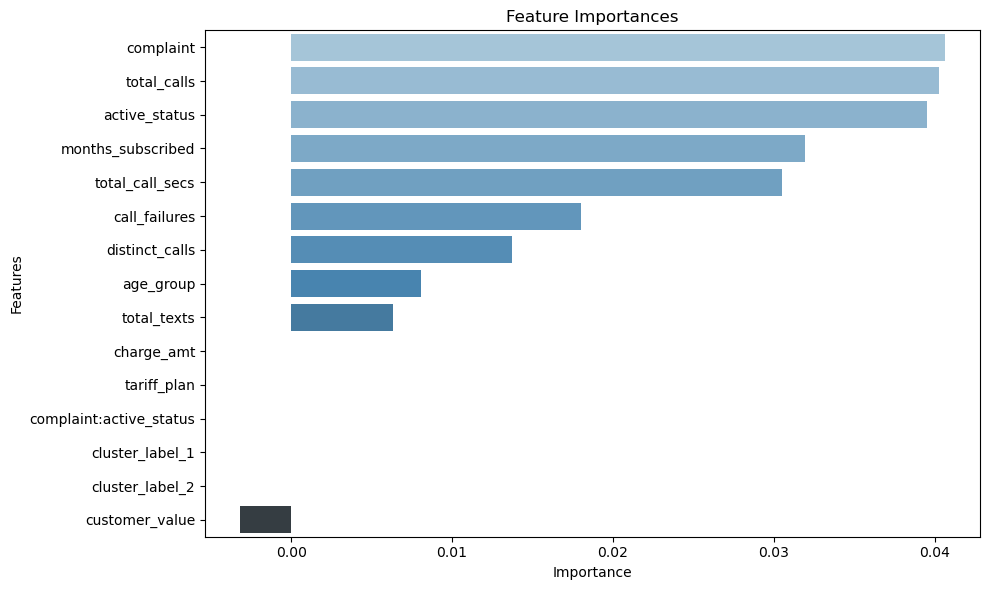

In [59]:
# Plot permutation feature importances
plot_feature_importances(feature_importances_dict)

## Pipeline Verification

In [60]:
# Inspect the data at different stages
def inspect_data_at_stage(original_pipeline, stage_name, X_data):
    """
    Inspects the transformed data at a specified stage in the pipeline.
    """
    # Create a new pipeline with the steps to inspect
    stage_index = list(original_pipeline.named_steps.keys()).index(stage_name)
    stages_to_include = list(original_pipeline.named_steps.items())[:stage_index + 1]
    stage_pipeline = Pipeline(stages_to_include)

    # Transform the data using the new pipeline
    X_transformed = stage_pipeline.transform(X_data)

    return X_transformed

# List of steps in pipeline to inspect
steps_to_inspect = ['clustering', 'scaling', 'interaction', 'encoding']

for step in steps_to_inspect:
    print(f"\nInspecting data at pipeline stage: {step}")
    transformed_data = inspect_data_at_stage(xgb_model, step, X_train)
    print("Transformed data columns:", transformed_data.columns.tolist())
    print("'cluster_label' in columns:", 'cluster_label' in transformed_data.columns)


Inspecting data at pipeline stage: clustering
Transformed data columns: ['call_failures', 'complaint', 'months_subscribed', 'charge_amt', 'total_call_secs', 'total_calls', 'total_texts', 'distinct_calls', 'age_group', 'tariff_plan', 'active_status', 'customer_value', 'cluster_label']
'cluster_label' in columns: True

Inspecting data at pipeline stage: scaling
Transformed data columns: ['call_failures', 'complaint', 'months_subscribed', 'charge_amt', 'total_call_secs', 'total_calls', 'total_texts', 'distinct_calls', 'age_group', 'tariff_plan', 'active_status', 'customer_value', 'cluster_label']
'cluster_label' in columns: True

Inspecting data at pipeline stage: interaction
Transformed data columns: ['call_failures', 'complaint', 'months_subscribed', 'charge_amt', 'total_call_secs', 'total_calls', 'total_texts', 'distinct_calls', 'age_group', 'tariff_plan', 'active_status', 'customer_value', 'cluster_label', 'complaint:active_status']
'cluster_label' in columns: True

Inspecting data a